In [285]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Podstawy Sztucznej Inteligencji WMII UJ 21/22
# Projekt *Heart Diseases* - Krzysztof Wydrzyński
W tym projekcie postaram się stworzyć model predykcyjny na podstawie Datsetu [Heart Disease Data Set](https://archive.ics.uci.edu/ml/datasets/Heart+Disease).

Pierwszym etapem będzie zaimportowanie, przygotowanie i oczyszczenie datasetu.

Najpierw ładuje dane z pliku, jeden rekord jest podzielony na 10 linijek. Chce posiadać jeden rekord w jednej linice, więc przeprowadzam następujące operacje na tych danych (usuwam 9 znaków końca lini, zostawiam 10-ty)

In [266]:
def get_content(file_name):
    in_file = './data/' + file_name + '.data'
    f = open(in_file, 'r', encoding="utf-8", errors='replace')
    content = f.read()
    f.close()
    return content

def process_data(content):
    iterator = 0
    result_process_data = ''
    for char in content:
        if char == '\n' and iterator != 10:
            iterator += 1
            result_process_data += ' '
        else:
            result_process_data += char

        if char == '\n' and iterator == 10:
            iterator = 0
            result_process_data += char
    return result_process_data

result_cleveland = process_data(get_content('cleveland'))

print(result_cleveland)

1 0 63 1 -9 -9 -9 -9 1 145 1 233 -9 50 20 1 -9 1 2 2 3 81 0 0 0 0 0 1 10.5 6 13 150 60 190 90 145 85 0 0 2.3 3 -9 172 0 -9 -9 -9 -9 -9 -9 6 -9 -9 -9 2 16 81 0 1 1 1 -9 1 -9 1 -9 1 1 1 1 1 1 1 -9 -9 name 
2 0 67 1 -9 -9 -9 -9 4 160 1 286 -9 40 40 0 -9 1 2 3 5 81 0 1 0 0 0 1 9.5 6 13 108 64 160 90 160 90 1 0 1.5 2 -9 185 3 -9 -9 -9 -9 -9 -9 3 -9 -9 -9 2 5 81 2 1 2 2 -9 2 -9 1 -9 1 1 1 1 1 1 1 -9 -9 name 
3 0 67 1 -9 -9 -9 -9 4 120 1 229 -9 20 35 0 -9 1 2 2 19 81 0 1 0 0 0 1 8.5 6 10 129 78 140 80 120 80 1 0 2.6 2 -9 150 2 -9 -9 -9 -9 -9 -9 7 -9 -9 -9 2 20 81 1 1 1 1 -9 1 -9 1 -9 2 2 1 1 1 7 3 -9 -9 name 
4 0 37 1 -9 -9 -9 -9 3 130 0 250 -9 0 0 0 -9 1 0 2 13 81 0 1 0 0 0 1 13 13 17 187 84 195 68 130 78 0 0 3.5 3 -9 167 0 -9 -9 -9 -9 -9 -9 3 -9 -9 -9 2 4 81 0 1 1 1 -9 1 -9 1 -9 1 1 1 1 1 1 1 -9 -9 name 
6 0 41 0 -9 -9 -9 -9 2 130 1 204 -9 0 0 0 -9 1 2 2 7 81 0 0 0 0 0 1 7 -9 9 172 71 160 74 130 86 0 0 1.4 1 -9 40 0 -9 -9 -9 -9 -9 -9 3 -9 -9 -9 2 18 81 0 1 1 1 -9 1 -9 1 -9 1 1 1 1 1 1 1 -9 

Zobaczmy, że dla result_cleveland od rekordu 299 włącznie nasze dane są zniekształcone (zawierają nieprawidłowe znaki). Pozbądźmy się danych od rekordu 299 do końca pliku i przeróbmy to na plik CSV, dołączając dane nazwy kolumn dostarczone w dokumentacji.

In [271]:
from io import StringIO

result = result_cleveland[0:54383]

csvStringIO = StringIO(result)
colnames = ['id', 'ccf', 'age', 'sex', 'painloc', 'painexer', 'relrest', 'pncaden', 'cp', 'trestbps', 'htn', 'chol', 'smoke', 'cigs', 'years', 'fbs', 'dm', 'famhist', 'restecg', 'ekgmo', 'ekgday', 'ekgyr', 'dig', 'prop', 'nitr', 'pro', 'diuretic', 'proto', 'thaldur', 'thaltime', 'met', 'thalach', 'thalrest', 'thpeakbps', 'thpeakbpd', 'dummy', 'trestbpd', 'exang', 'xhypo', 'oldpeak', 'slope', 'rldv5', 'rldv5e', 'ca', 'restckm', 'exerckm', 'restef', 'restwm', 'exeref', 'exerwm', 'thal', 'thalsev', 'thalpul', 'earlobe', 'cmo', 'cday', 'cyr', 'num', 'lmt', 'ladprox', 'laddist', 'diag','cxmain','ramus','om1','om2','rcaprox','rcadist', 'lvx1', 'lvx2', 'lvx3', 'lvx4', 'lvf', 'cathef', 'junk', 'name', '']

df = pd.read_csv(csvStringIO, sep=" ", names=colnames, header=None)

df

,id,ccf,age,sex,painloc,painexer,relrest,pncaden,cp,trestbps,...,rcadist,lvx1,lvx2,lvx3,lvx4,lvf,cathef,junk,name,
0,1,0,63,1,-9,-9,-9,-9,1,145,...,1,1,1,1,1,1,-9,-9,name,NaN
1,2,0,67,1,-9,-9,-9,-9,4,160,...,1,1,1,1,1,1,-9,-9,name,NaN
2,3,0,67,1,-9,-9,-9,-9,4,120,...,2,1,1,1,7,3,-9,-9,name,NaN
3,4,0,37,1,-9,-9,-9,-9,3,130,...,1,1,1,1,1,1,-9,-9,name,NaN
4,6,0,41,0,-9,-9,-9,-9,2,130,...,1,1,1,1,1,1,-9,-9,name,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,280,0,44,1,-9,-9,-9,-9,3,120,...,1,1,1,1,1,1,-9,-9,name,NaN
264,281,0,61,1,-9,-9,-9,-9,4,138,...,1,1,1,1,5,1,-9,-9,name,NaN
265,282,0,42,1,-9,-9,-9,-9,4,136,...,1,1,1,1,1,1,-9,-9,name,NaN
266,283,0,52,1,-9,-9,-9,-9,4,128,...,2,1,1,6,5,2,-9,-9,name,NaN


Sczegółowy opis danych znajduje się w pliku heart-disease.names
Najważniejsze z nich to:
* age - wiek
* sex - płeć (1 = mężczyzna, 0 = kobieta)
* cp - typ bólu klatki piersiowej:
  * 1 - typowa dusznica
  * 2 - nietypowa dusznica
  * 3 - ból niedusznicowy
  * 4 - brak symptomów
* trestbps - ciśnienie krwi w spoczynku (mm Hg)
* chol - cholesterol (mg/dl)
* fbs - czy cukier krwi na czczo > 120 mg/dl (1 - tak, 0 - nie)
* restecg - wyniki Elektrokardiografii:
  * 0 - norma
  * 1 - zaburzenie ST-T
  * 2 - prawdopodobnu lub definitywny przerost komór
* thalach - maksymalne tętno
* exang - dławica piersiowa wywołana wysiłkiem fizycznym
* oldpeak - obniżenie odcinka ST wywołane wysiłkiem fizycznym w stosunku do spoczynku
* slope - nachylenie szczytowego odcinka ST
* ca - liczba głównych naczyń (0-3) pokolorowanych fluorozopią
* num - diagnoza chroby serca

Dane te są pokazane opisane w pliku jako te które były używane przez zespoły zajmujące się ML na tym datasecie.
W następnej komórce obrabiam dane, tak aby zostały nam tylko potrzebne kolumny.

In [272]:
df2 = df[['age', 'sex', 'cp', 'trestbps', 'chol', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']]

Sprawdzam czy nie ma nulli

In [273]:
df2.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64

Czy wszystkie kolumny są reprezentowane jako kolumny numeryczne

In [274]:
print("Data types and their frequency\n{}".format(df2.dtypes.value_counts()))

Data types and their frequency
int64      12
float64     1
dtype: int64


Dane wyglądają następująco

In [255]:
df2.head()

,age,sex,cp,trestbps,chol,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286,2,108,1,1.5,2,3,3,2
2,67,1,4,120,229,2,129,1,2.6,2,2,7,1
3,37,1,3,130,250,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,2,172,0,1.4,1,0,3,0


Będziemy chcieli przewidzeć kolumne num (diagnoza choroby serca) obecnie posiada ona wartości 0-3 (gdzie 0 - brak, >1 - diagnoza choroby serca).
Ponieważ mam zamiar zastosować klasyfikator binarny, chcę spłaszczyć tę danę jedynie do 0, lub 1:

In [275]:
df2['target'] = np.where(df2['num'] > 0, 1, 0)
df2.head()

C:\Users\krzys\AppData\Local\Temp\ipykernel_10024\3091332261.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['target'] = np.where(df2['num'] > 0, 1, 0)


,age,sex,cp,trestbps,chol,restecg,thalach,exang,oldpeak,slope,ca,thal,num,target
0,63,1,1,145,233,2,150,0,2.3,3,0,6,0,0
1,67,1,4,160,286,2,108,1,1.5,2,3,3,2,1
2,67,1,4,120,229,2,129,1,2.6,2,2,7,1,1
3,37,1,3,130,250,0,187,0,3.5,3,0,3,0,0
4,41,0,2,130,204,2,172,0,1.4,1,0,3,0,0


Teraz możemy usunąć starą kolumne i ustalić nasze X i y

In [276]:
df2 = df2.drop('num', axis=1)
print(df2.head())

X = df2.drop('target', axis=1)
y = df2[['target']].values.ravel()

   age  sex  cp  trestbps  chol  restecg  thalach  exang  oldpeak  slope  ca  \
0   63    1   1       145   233        2      150      0      2.3      3   0   
1   67    1   4       160   286        2      108      1      1.5      2   3   
2   67    1   4       120   229        2      129      1      2.6      2   2   
3   37    1   3       130   250        0      187      0      3.5      3   0   
4   41    0   2       130   204        2      172      0      1.4      1   0   

   thal  target  
0     6       0  
1     3       1  
2     7       1  
3     3       0  
4     3       0  


# Wizualizacja datasetu

ilość przypadków prawdziwych i nie

<AxesSubplot:xlabel='target', ylabel='count'>

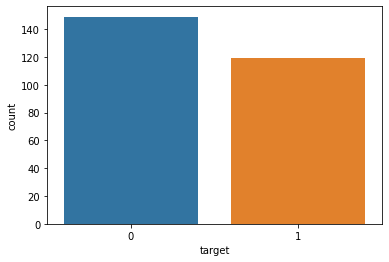

In [281]:
sns.countplot(x = 'target',data = df2)

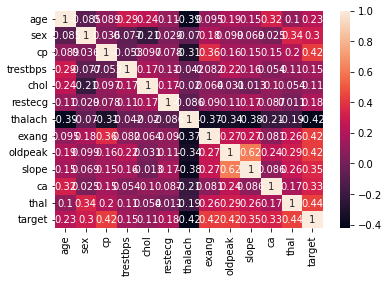

In [290]:
sns.heatmap(df2.corr(), annot=True)
plt.show()

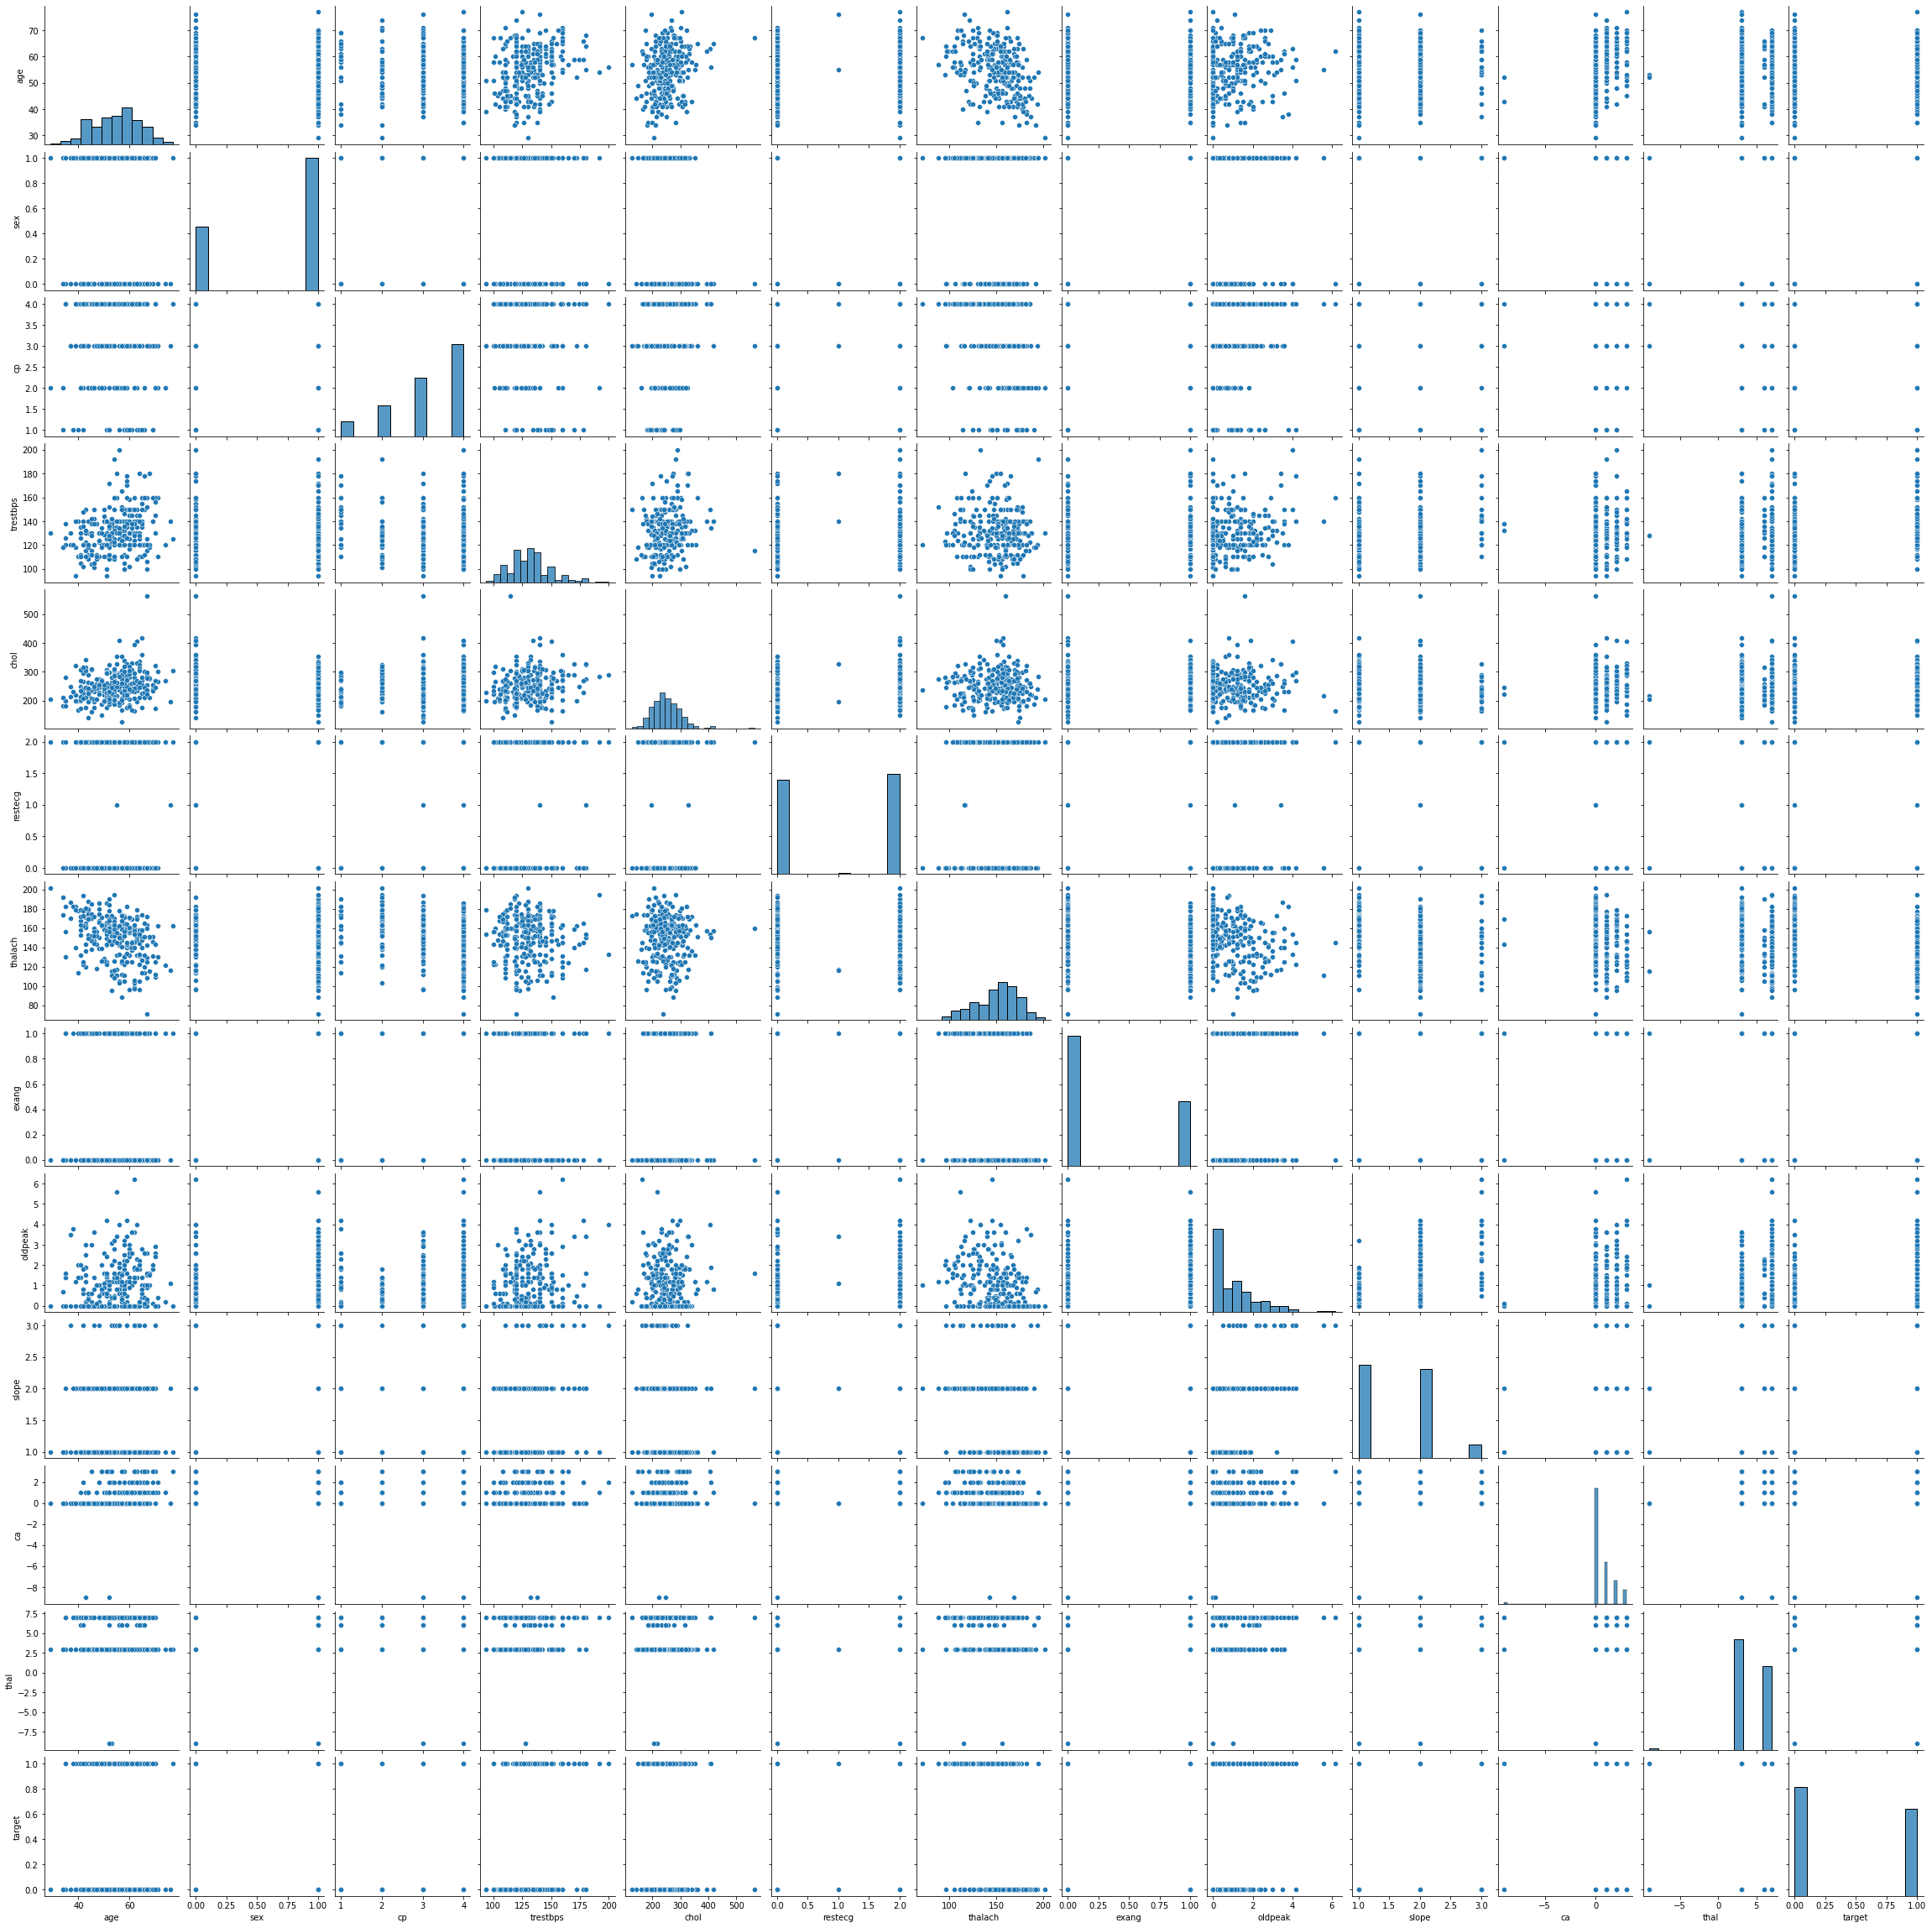

In [291]:
sns.pairplot(df2)
plt.show()

# Tworzenie Pipeline
Stwórzmy następujące pipeline:
* dla SVM z jądrem rbf
* dla SVM z jądrem poly
* dla SVM liniowego
* dla regresji logistycznej

W preprocessingu będziemy również używać sklaowania danych, użyjemy *StandardScaler()*

In [277]:
svm_pipeline = Pipeline([('scale', StandardScaler()),
                                 ('classifier', SVC())])

logistic_pipeline = Pipeline([('scale', StandardScaler()),
                                 ('classifier', LogisticRegression())])

Po utworzeniu pipeline, możemy się wziąć za tworzenie *GridSearch*

In [278]:
seed=123
kfold = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)


svm_param_grid = {
    'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__kernel': ['rbf', 'poly', 'linear']
}

logistic_param_grid = {
      'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
}

svm_rbf_grid_search = GridSearchCV(svm_pipeline,
                                  param_grid=svm_param_grid,
                                  cv=kfold,
                                  refit=False)

logistic_grid_search = GridSearchCV(logistic_pipeline,
                                  param_grid=logistic_param_grid,
                                  cv=kfold,
                                  refit=False)

grid_searches = [svm_rbf_grid_search, logistic_grid_search]

for grid in grid_searches:
    grid.fit(X, y)
    print(grid.best_score_)
    print(grid.best_params_)

def find_best(grids):
    best = grids[0]
    for g in grids:
        if g.best_score_ > best.best_score_:
            best = g
    return best



0.8395527603074772
{'classifier__C': 0.01, 'classifier__gamma': 0.001, 'classifier__kernel': 'linear'}
0.8319357092941999
{'classifier__C': 0.01}
